In [221]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import RectBivariateSpline as rbs
from scipy.integrate import romb
import scipy.sparse as sp
import os
import pywt
wvt = 'db12'
%matplotlib inline
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0.0,vmax=1.5)

In [222]:
nx = ny = 32
t = np.linspace(0,320,nx+1)
s = np.linspace(0,320,17)


x = y = (t[:-1]+t[1:]) / 2

x = y = (t[:-1]+t[1:]) / 2
xst = yst = (s[:-1]+s[1:]) / 2

xs, ys = np.meshgrid(xst,yst)
xs = xs.flatten()
ys = ys.flatten()

In [223]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, axis=0):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=axis)
    return y

def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, [low], btype='low')
    return b, a


def butter_low_filter(data, lowcut, fs, order=5, axis=0):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = lfilter(b, a, data, axis=axis)
    return y

In [224]:
shot = np.reshape(np.fromfile("Testing/TestData/shot1.dat", dtype=np.float32), (4001,64,64))
t = np.linspace(0, 0.5, 4001)
shotf = butter_low_filter(shot, 10, 8000)
tf = t[::20]
shotf = shotf[::20,:,:]
tf_freq = 1/(tf[1]-tf[0])

xc = np.linspace(0,320,65)
xc = (xc[:-1]+xc[1:])/2
yc = xc

In [225]:
shotf_itps = [rbs(xc, yc, s) for s in shotf[:-1]]

In [226]:
def reconstruction(w, wvt_lens, wvt):
    starts = np.hstack([0,np.cumsum(wvt_lens)])
    wcoef = [w[starts[i]:starts[i+1]] for i in range(len(wvt_lens))]
    return pywt.waverec(wcoef, wvt)

# ZigZag

In [227]:
das_template_x = np.array([2.5*np.sqrt(2)*i for i in range(24)])
das_template_y = np.array([2.5*np.sqrt(2)*i for i in range(24)])
das_template_x2 = np.hstack([das_template_x,das_template_x[::-1],das_template_x,das_template_x[::-1]])
das_template_y2 = np.hstack([das_template_y,das_template_y+das_template_y[-1],das_template_y+2*das_template_y[-1],das_template_y+3*das_template_y[-1]])

das_x = np.hstack([das_template_x2+i*das_template_x[-1] for i in range(4)])
das_y = np.hstack([das_template_y2 for i in range(4)])

offset = (320-np.max(das_x))/2

das_x += offset
das_y += offset

azimuth_template_1 = np.array([[[45 for i in range(24)], [-45 for i in range(24)]] for i in range(2)]).flatten()
azimuth_template_2 = np.array([[[135 for i in range(24)], [215 for i in range(24)]] for i in range(2)]).flatten()
das_az = np.hstack([azimuth_template_1, azimuth_template_2, 
                    azimuth_template_1, azimuth_template_2])

raz = np.deg2rad(das_az)


cscale = 2

generate_kernels = True


L = 10 #gauge length
ll = np.linspace(-L/2, L/2, 2**5+1)
dl = ll[1]-ll[0]
p1 = das_x[:,np.newaxis]+np.sin(raz[:,np.newaxis])*ll[np.newaxis,:]
p2 = das_y[:,np.newaxis]+np.cos(raz[:,np.newaxis])*ll[np.newaxis,:]


if generate_kernels:
    os.makedirs("Kernels", exist_ok=True)
    crv = loadmat(f"../Curvelet_Basis_Construction/G_{nx}_{ny}.mat")
    G_mat = np.reshape(crv["G_mat"].T, (crv["G_mat"].shape[1], nx, ny))
    crvscales = crv["scales"].flatten()
    cvtscaler = 2.0**(cscale*crvscales)
    G1 = np.zeros((len(raz), G_mat.shape[0]))
    G2 = np.zeros((len(raz), G_mat.shape[0]))
    G3 = np.zeros((len(xs), G_mat.shape[0]))             
    for j in range(G_mat.shape[0]):
        frame = rbs(x,y,G_mat[j])
        #average derivatives of frame along gauge length
        fd1 = romb(frame.ev(p1, p2, dx=1), dl) / L
        fd2 = romb(frame.ev(p1, p2, dy=1), dl) / L
        G1[:,j] = (np.sin(raz)**2*fd1 + 
                  np.sin(2*raz)*fd2/2) / cvtscaler[j]
        G2[:,j] = (np.cos(raz)**2*fd2 + 
                  np.sin(2*raz)*fd1/2) / cvtscaler[j]
        G3[:,j] = frame.ev(xs, ys) / cvtscaler[j]

        
    G = np.hstack([G1, G2])
    Gn = np.max(np.sqrt(np.sum(G**2, axis=1)))
    G = G / Gn
#     Gn=1
    G_zigzag = G

In [228]:
np.linalg.slogdet(G.T@G+1e-10*np.eye(G.shape[1]))

(1.0, -125326.32695040845)

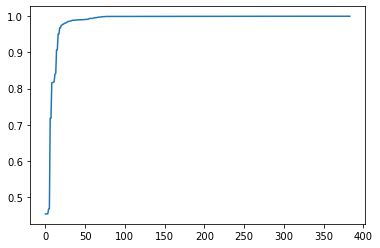

In [229]:
plt.plot(np.sort(np.diag(G @ np.linalg.solve(G.T@G + 1e-10*np.eye(G.shape[1]), G.T))))

In [230]:
exxr = np.array([romb(s.ev(p1, p2, dx=2), dl)/L for s in shotf_itps])
eyyr = np.array([romb(s.ev(p1, p2, dy=2), dl)/L for s in shotf_itps])
exyr = np.array([romb(s.ev(p1, p2, dx=1, dy=1), dl)/L  for s in shotf_itps])
edasr = (np.sin(raz)**2*exxr+np.sin(2*raz)*exyr+np.cos(raz)**2*eyyr) 
das_wvt_data = np.array([np.hstack(pywt.wavedec(d, wvt)) for d in edasr.T])

cuxr = np.array([s.ev(xs, ys, dx=1) for s in shotf_itps])
cuyr = np.array([s.ev(xs, ys, dy=1) for s in shotf_itps])



np.save("Testing/zigzag.npy", das_wvt_data)

In [231]:
wvt_tmp = pywt.wavedec(edasr.T[0], wvt)
wvt_lens = [len(wc) for wc in wvt_tmp]

In [232]:
resi = np.load(f"Testing/zigzag_res.npy")

Gs = np.std(G)

resxi = resi[:G3.shape[1], :]
resyi = resi[G3.shape[1]:, :]

xpredi = (G3/Gn/Gs) @ resxi
ypredi = (G3/Gn/Gs) @ resyi


txpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in xpredi]))
typredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in ypredi]))


res = np.sqrt(np.mean(np.hstack([np.square(txpredi-cuxr.T), np.square(typredi-cuyr.T)])))/np.std(np.hstack([cuxr, cuyr]))


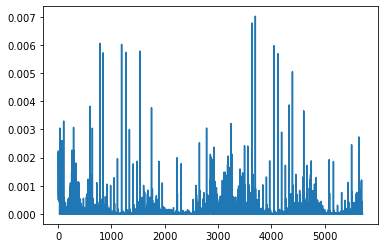

In [233]:
plt.plot(np.std(resi, axis=1))

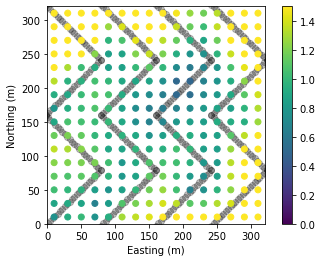

In [234]:
cax = plt.scatter(das_x, das_y,color='k', alpha=0.25)
plt.xlim(0,320)
plt.ylim(0,320)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

plt.scatter(xs, ys, c=  np.sqrt(np.mean(np.hstack([np.square(txpredi-cuxr.T)/np.std(cuxr, axis=0)[:,np.newaxis]**2, np.square(typredi-cuyr.T)/np.std(cuyr, axis=0)[:,np.newaxis]**2]), axis=1))
, norm=norm)
plt.colorbar()

In [235]:
res

1.0372970276955595

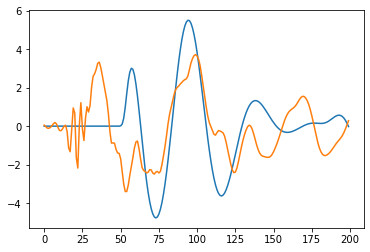

In [236]:
plt.plot(cuxr.T[100])
plt.plot(txpredi[100])

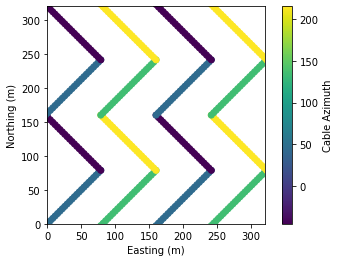

In [237]:
cax = plt.scatter(das_x, das_y,c=das_az)
plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Cable Azimuth")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")


In [238]:
np.sqrt(np.square(das_x[1:]-das_x[:-1])+np.square(das_y[1:]-das_y[:-1]))

array([  5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   0.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   0.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.  

# Spiral

In [239]:
das_theta2 = np.linspace(0,(360*4)**2, 192*2)
das_theta = np.deg2rad(np.sqrt(das_theta2))
a = 0
b = 1
das_r = b*das_theta

das_x = das_r * np.cos(das_theta)
das_y = das_r * np.sin(das_theta)
raz = np.pi/2-np.arctan2(b*np.tan(das_theta)+(a+b*das_theta), b-(a+b*das_theta)*np.tan(das_theta))
das_az = np.rad2deg(raz)

xwidth = np.max(das_x)-np.min(das_x)
das_x = das_x / xwidth * 320
das_y = das_y / xwidth * 320
x_offset = 320 - np.max(das_x)
das_x = das_x + x_offset
y_offset = np.min(das_y)
das_y = das_y - y_offset

L = 10 #gauge length
ll = np.linspace(-L/2, L/2, 2**5+1)
dl = ll[1]-ll[0]
p1 = das_x[:,np.newaxis]+np.sin(raz[:,np.newaxis])*ll[np.newaxis,:]
p2 = das_y[:,np.newaxis]+np.cos(raz[:,np.newaxis])*ll[np.newaxis,:]


if generate_kernels:
    os.makedirs("Kernels", exist_ok=True)
    crv = loadmat(f"../Curvelet_Basis_Construction/G_{nx}_{ny}.mat")
    G_mat = np.reshape(crv["G_mat"].T, (crv["G_mat"].shape[1], nx, ny))
    crvscales = crv["scales"].flatten()
    cvtscaler = 2.0**(cscale*crvscales)
    G1 = np.zeros((len(raz), G_mat.shape[0]))
    G2 = np.zeros((len(raz), G_mat.shape[0]))
    for j in range(G_mat.shape[0]):
        frame = rbs(x,y,G_mat[j])
        #average derivatives of frame along gauge length
        fd1 = romb(frame.ev(p1, p2, dx=1), dl) / L
        fd2 = romb(frame.ev(p1, p2, dy=1), dl) / L
        G1[:,j] = (np.sin(raz)**2*fd1 + 
                  np.sin(2*raz)*fd2/2) / cvtscaler[j]
        G2[:,j] = (np.cos(raz)**2*fd2 + 
                  np.sin(2*raz)*fd1/2) / cvtscaler[j]
        
    G = np.hstack([G1, G2])
    Gn = np.max(np.sqrt(np.sum(G**2, axis=1)))
    G = G / Gn
    G_spiral = G

In [240]:
np.linalg.slogdet(G.T@G+1e-10*np.eye(G.shape[1]))

(1.0, -125143.20530042966)

In [241]:
exxr = np.array([romb(s.ev(p1, p2, dx=2), dl)/L for s in shotf_itps])
eyyr = np.array([romb(s.ev(p1, p2, dy=2), dl)/L for s in shotf_itps])
exyr = np.array([romb(s.ev(p1, p2, dx=1, dy=1), dl)/L  for s in shotf_itps])
edasr = (np.sin(raz)**2*exxr+np.sin(2*raz)*exyr+np.cos(raz)**2*eyyr) 
das_wvt_data = np.array([np.hstack(pywt.wavedec(d, wvt)) for d in edasr.T])

np.save("Testing/spiral.npy", das_wvt_data)

In [242]:
resi = np.load(f"Testing/spiral_res.npy")

Gs = np.std(G)

resxi = resi[:G3.shape[1], :]
resyi = resi[G3.shape[1]:, :]

xpredi = (G3/Gn/Gs) @ resxi
ypredi = (G3/Gn/Gs) @ resyi


txpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in xpredi]))
typredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in ypredi]))


res = np.sqrt(np.mean(np.hstack([np.square(txpredi-cuxr.T), np.square(typredi-cuyr.T)])))/np.std(np.hstack([cuxr, cuyr]))


In [243]:
res

0.9398445495149351

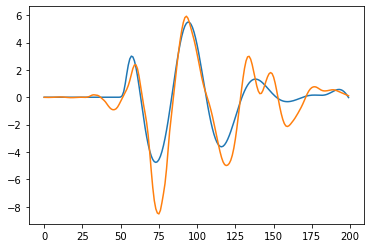

In [244]:
plt.plot(cuxr.T[100])
plt.plot(txpredi[100])

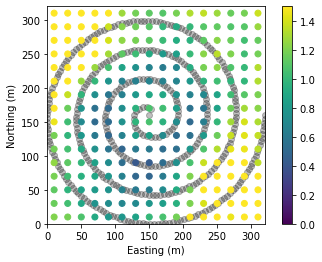

In [245]:
cax = plt.scatter(das_x, das_y,color='k', alpha=0.25)
plt.xlim(0,320)
plt.ylim(0,320)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

plt.scatter(xs, ys, c=  np.sqrt(np.mean(np.hstack([np.square(txpredi-cuxr.T)/np.std(cuxr, axis=0)[:,np.newaxis]**2, np.square(typredi-cuyr.T)/np.std(cuyr, axis=0)[:,np.newaxis]**2]), axis=1))
, norm=norm)
plt.colorbar()

In [246]:
np.hstack([cuxr, cuyr]).shape

(200, 512)

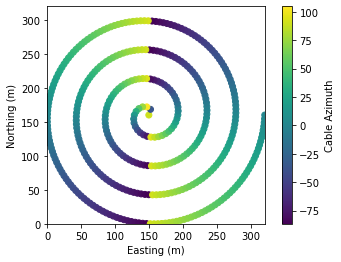

In [247]:
cax = plt.scatter(das_x, das_y,c=das_az)
plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Cable Azimuth")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")


In [248]:
np.sqrt(np.square(das_x[1:]-das_x[:-1])+np.square(das_y[1:]-das_y[:-1]))

array([8.71702842, 6.53716321, 6.18531665, 6.02640617, 5.93537092,
       5.87628203, 5.83480707, 5.80408236, 5.78040382, 5.76159509,
       5.74629299, 5.73359998, 5.72290088, 5.71375991, 5.70585968,
       5.69896355, 5.69289149, 5.68750408, 5.68269167, 5.67836686,
       5.67445911, 5.67091085, 5.66767464, 5.66471106, 5.66198704,
       5.65947465, 5.65715016, 5.65499325, 5.65298641, 5.65111452,
       5.6493644 , 5.64772454, 5.64618485, 5.64473641, 5.64337135,
       5.64208267, 5.64086413, 5.63971015, 5.63861574, 5.6375764 ,
       5.63658808, 5.63564711, 5.63475016, 5.63389423, 5.63307654,
       5.63229461, 5.63154613, 5.630829  , 5.6301413 , 5.62948124,
       5.6288472 , 5.62823766, 5.62765124, 5.62708663, 5.62654266,
       5.62601819, 5.62551222, 5.62502376, 5.62455194, 5.62409591,
       5.62365489, 5.62322816, 5.62281502, 5.62241485, 5.62202705,
       5.62165103, 5.62128629, 5.62093231, 5.62058863, 5.62025481,
       5.61993042, 5.61961507, 5.6193084 , 5.61901004, 5.61871

# Crossing

In [249]:
template = np.linspace(0,320, 65)
template = (template[1:]+template[:-1])/2

das_x = np.hstack([template, template, template,[80 for i in range(len(template))], [160 for i in range(len(template))], [240 for i in range(len(template))]])
das_y = np.hstack([[80 for i in range(len(template))], [160 for i in range(len(template))], [240 for i in range(len(template))],template,template,template])
das_az = np.hstack([[90 for i in range(len(template))], [270 for i in range(len(template))], [90 for i in range(len(template))],[0 for i in range(len(template))], [180 for i in range(len(template))], [0 for i in range(len(template))]])
raz = np.deg2rad(das_az)

L = 10 #gauge length
ll = np.linspace(-L/2, L/2, 2**5+1)
dl = ll[1]-ll[0]
p1 = das_x[:,np.newaxis]+np.sin(raz[:,np.newaxis])*ll[np.newaxis,:]
p2 = das_y[:,np.newaxis]+np.cos(raz[:,np.newaxis])*ll[np.newaxis,:]


if generate_kernels:
    os.makedirs("Kernels", exist_ok=True)
    crv = loadmat(f"../Curvelet_Basis_Construction/G_{nx}_{ny}.mat")
    G_mat = np.reshape(crv["G_mat"].T, (crv["G_mat"].shape[1], nx, ny))
    crvscales = crv["scales"].flatten()
    cvtscaler = 2.0**(cscale*crvscales)
    G1 = np.zeros((len(raz), G_mat.shape[0]))
    G2 = np.zeros((len(raz), G_mat.shape[0]))
    for j in range(G_mat.shape[0]):
        frame = rbs(x,y,G_mat[j])
        #average derivatives of frame along gauge length
        fd1 = romb(frame.ev(p1, p2, dx=1), dl) / L
        fd2 = romb(frame.ev(p1, p2, dy=1), dl) / L
        G1[:,j] = (np.sin(raz)**2*fd1 + 
                  np.sin(2*raz)*fd2/2) / cvtscaler[j]
        G2[:,j] = (np.cos(raz)**2*fd2 + 
                  np.sin(2*raz)*fd1/2) / cvtscaler[j]
        
    G = np.hstack([G1, G2])
    Gn = np.max(np.sqrt(np.sum(G**2, axis=1)))
    G = G / Gn
    G_cross = G

In [250]:
np.linalg.slogdet(G.T@G+1e-10*np.eye(G.shape[1]))

(1.0, -128297.3643901952)

In [251]:
exxr = np.array([romb(s.ev(p1, p2, dx=2), dl)/L for s in shotf_itps])
eyyr = np.array([romb(s.ev(p1, p2, dy=2), dl)/L for s in shotf_itps])
exyr = np.array([romb(s.ev(p1, p2, dx=1, dy=1), dl)/L  for s in shotf_itps])
edasr = (np.sin(raz)**2*exxr+np.sin(2*raz)*exyr+np.cos(raz)**2*eyyr) 
das_wvt_data = np.array([np.hstack(pywt.wavedec(d, wvt)) for d in edasr.T])

np.save("Testing/crossing.npy", das_wvt_data )

In [252]:
resi = np.load(f"Testing/crossing_res.npy")

Gs = np.std(G)

resxi = resi[:G3.shape[1], :]
resyi = resi[G3.shape[1]:, :]

xpredi = (G3/Gn/Gs) @ resxi
ypredi = (G3/Gn/Gs) @ resyi


txpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in xpredi]))
typredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in ypredi]))


res = np.sqrt(np.mean(np.hstack([np.square(txpredi-cuxr.T), np.square(typredi-cuyr.T)])))/np.std(np.hstack([cuxr, cuyr]))


In [253]:
res

0.7821658463682866

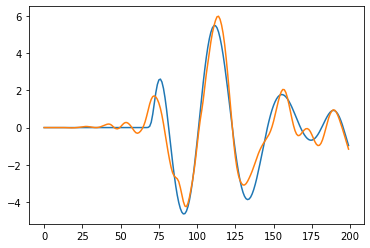

In [254]:
plt.plot(cuxr.T[150])
plt.plot(txpredi[150])

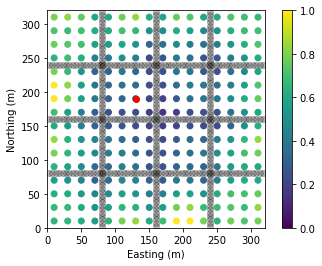

In [255]:
cax = plt.scatter(das_x, das_y,color='k', alpha=0.25)
plt.xlim(0,320)
plt.ylim(0,320)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

plt.scatter(xs, ys, c=  np.sqrt(np.mean(np.hstack([np.square(txpredi-cuxr.T)/np.std(cuxr, axis=0)[:,np.newaxis]**2, np.square(typredi-cuyr.T)/np.std(cuyr, axis=0)[:,np.newaxis]**2]), axis=1))
, norm=norm)
plt.scatter(xs[150], ys[150], color='r')
plt.colorbar()

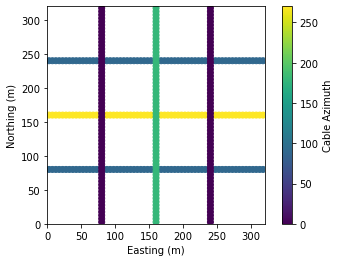

In [256]:
cax = plt.scatter(das_x, das_y,c=das_az)
plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Cable Azimuth")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

# Random

In [257]:
template = np.linspace(0,320, 65)
template = (template[1:]+template[:-1])/2

np.random.seed(94899109)
das_x = np.random.uniform(5,315,384)
das_y = np.random.uniform(5,315,384)
das_az = np.random.uniform(0,360,384)

raz = np.deg2rad(das_az)

L = 10 #gauge length
ll = np.linspace(-L/2, L/2, 2**5+1)
dl = ll[1]-ll[0]
p1 = das_x[:,np.newaxis]+np.sin(raz[:,np.newaxis])*ll[np.newaxis,:]
p2 = das_y[:,np.newaxis]+np.cos(raz[:,np.newaxis])*ll[np.newaxis,:]


if generate_kernels:
    os.makedirs("Kernels", exist_ok=True)
    crv = loadmat(f"../Curvelet_Basis_Construction/G_{nx}_{ny}.mat")
    G_mat = np.reshape(crv["G_mat"].T, (crv["G_mat"].shape[1], nx, ny))
    crvscales = crv["scales"].flatten()
    cvtscaler = 2.0**(cscale*crvscales)
    G1 = np.zeros((len(raz), G_mat.shape[0]))
    G2 = np.zeros((len(raz), G_mat.shape[0]))
    for j in range(G_mat.shape[0]):
        frame = rbs(x,y,G_mat[j])
        #average derivatives of frame along gauge length
        fd1 = romb(frame.ev(p1, p2, dx=1), dl) / L
        fd2 = romb(frame.ev(p1, p2, dy=1), dl) / L
        G1[:,j] = (np.sin(raz)**2*fd1 + 
                  np.sin(2*raz)*fd2/2) / cvtscaler[j]
        G2[:,j] = (np.cos(raz)**2*fd2 + 
                  np.sin(2*raz)*fd1/2) / cvtscaler[j]
        
    G = np.hstack([G1, G2])
    Gn = np.max(np.sqrt(np.sum(G**2, axis=1)))
    G = G / Gn
    G_random = G

In [258]:
np.linalg.slogdet(G.T@G+1e-10*np.eye(G.shape[1]))

(1.0, -123055.84036052768)

In [259]:
exxr = np.array([romb(s.ev(p1, p2, dx=2), dl)/L for s in shotf_itps])
eyyr = np.array([romb(s.ev(p1, p2, dy=2), dl)/L for s in shotf_itps])
exyr = np.array([romb(s.ev(p1, p2, dx=1, dy=1), dl)/L  for s in shotf_itps])
edasr = (np.sin(raz)**2*exxr+np.sin(2*raz)*exyr+np.cos(raz)**2*eyyr) 
das_wvt_data = np.array([np.hstack(pywt.wavedec(d, wvt)) for d in edasr.T])

np.save("Testing/random.npy", das_wvt_data)

In [260]:
resi = np.load(f"Testing/random_res.npy")

Gs = np.std(G)

resxi = resi[:G3.shape[1], :]
resyi = resi[G3.shape[1]:, :]

xpredi = (G3/Gn/Gs) @ resxi
ypredi = (G3/Gn/Gs) @ resyi


txpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in xpredi]))
typredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in ypredi]))


res = np.sqrt(np.mean(np.hstack([np.square(txpredi-cuxr.T), np.square(typredi-cuyr.T)])))/np.std(np.hstack([cuxr, cuyr]))


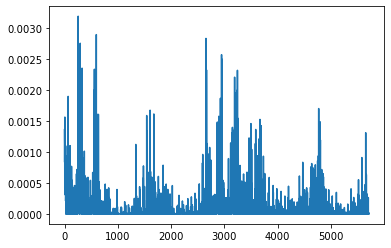

In [261]:
plt.plot(np.std(resi, axis=1))

In [262]:
res

0.4333884596406111

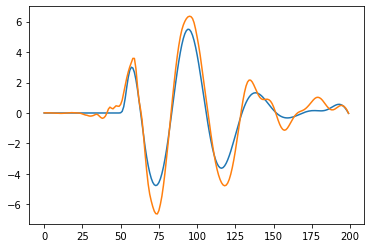

In [263]:
plt.plot(cuxr.T[100])
plt.plot(txpredi[100])

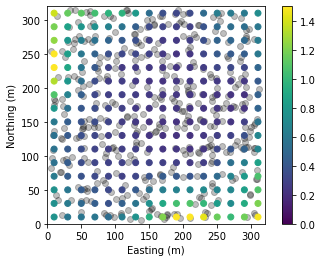

In [264]:
cax = plt.scatter(das_x, das_y,color='k', alpha=0.25)
plt.xlim(0,320)
plt.ylim(0,320)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

plt.scatter(xs, ys, c=  np.sqrt(np.mean(np.hstack([np.square(txpredi-cuxr.T)/np.std(cuxr, axis=0)[:,np.newaxis]**2, np.square(typredi-cuyr.T)/np.std(cuyr, axis=0)[:,np.newaxis]**2]), axis=1))
, norm=norm)
plt.colorbar()

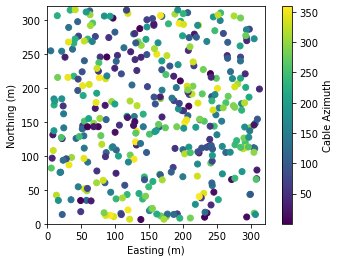

In [265]:
cax = plt.scatter(das_x, das_y,c=das_az)
plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Cable Azimuth")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

In [266]:
np.save("Kernels/G_zigzag.npy", G_zigzag)
np.save("Kernels/G_spiral.npy", G_spiral)
np.save("Kernels/G_cross.npy", G_cross)
np.save("Kernels/G_random.npy", G_random)

# Eigenvalue Spectrum

In [267]:
G_full = np.vstack([np.hstack([G3, np.zeros(G3.shape)]), np.hstack([np.zeros(G3.shape), G3])])

idet = 1e-10*np.eye(G_zigzag.shape[1])
ezig = np.sort(np.linalg.eigvals(G_zigzag.T@G_zigzag+idet))[::-1]
espi = np.sort(np.linalg.eigvals(G_spiral.T@G_spiral+idet))[::-1]
ecro = np.sort(np.linalg.eigvals(G_cross.T@G_cross+idet))[::-1]
eran = np.sort(np.linalg.eigvals(G_random.T@G_random+idet))[::-1]
# efull= np.sort(np.linalg.eigvals(G_full.T@G_full+idet))[::-1]

ezign = ezig / ezig[0]
espin = espi / espi[0]
ecron = ecro / ecro[0]
erann = eran / eran[0]
# efulln = efull / efull[0]


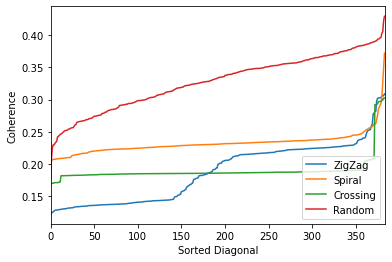

In [268]:
plt.plot(np.sort(np.diag(G_zigzag @ np.linalg.solve(G_zigzag.T@G_zigzag + 1e-0*np.eye(G_zigzag.shape[1]), G_zigzag.T))), label="ZigZag")
plt.plot(np.sort(np.diag(G_spiral @ np.linalg.solve(G_spiral.T@G_spiral + 1e-0*np.eye(G_spiral.shape[1]), G_spiral.T))), label="Spiral")
plt.plot(np.sort(np.diag(G_cross @ np.linalg.solve(G_cross.T@G_cross + 1e-0*np.eye(G_cross.shape[1]), G_cross.T))), label="Crossing")
plt.plot(np.sort(np.diag(G_random @ np.linalg.solve(G_random.T@G_random + 1e-0*np.eye(G_random.shape[1]), G_random.T))), label="Random")

plt.xlim(0,384)
plt.ylabel("Coherence")
plt.xlabel("Sorted Diagonal")
plt.legend(loc="lower right")

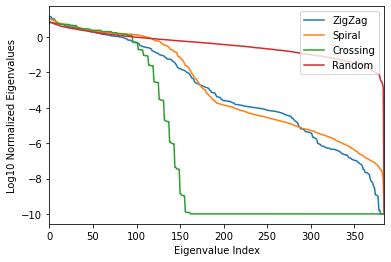

In [269]:
plt.plot(np.log10(np.real(ezig)), label="ZigZag")
plt.plot(np.log10(np.real(espi)), label="Spiral")
plt.plot(np.log10(np.real(ecro)), label="Crossing")
plt.plot(np.log10(np.real(eran)), label="Random")

plt.xlim(0,384)
plt.ylabel("Log10 Normalized Eigenvalues")
plt.xlabel("Eigenvalue Index")
plt.legend(loc="upper right")